In [1]:
import pandas as pd
import networkx as nx
import os
import pickle
import time

In [14]:
root_dir = "/media/visionin/data_station/OctanData/BSC/running/2022_old_data/save_dir/"

In [3]:
# data source
path_0 = "/media/visionin/data_station/OctanData/BSC/running/2022_old_data/clean_data"


In [5]:
data_list = [path_0]

In [6]:
frames = []

In [7]:
# load data into frames
for data_path in data_list:
    for filename in os.listdir(data_path):
        if filename.endswith(".csv"):

            csv_file = data_path + "/" + filename

            print(filename)

            raw_data = pd.read_csv(csv_file)

            # save to csv
            frames.append(raw_data)

            # refresh memory
            del raw_data

10_bsc_v1.csv
11_bsc_v1.csv
12_bsc_v1.csv
13_bsc_v1.csv
14_bsc_v1.csv
15_bsc_v1.csv
16_bsc_v1.csv
17_bsc_v1.csv
18_bsc_v1.csv
19_bsc_v1.csv
1_bsc_v1.csv
20_bsc_v1.csv
21_bsc_v1.csv
22_bsc_v1.csv
23_bsc_v1.csv
24_bsc_v1.csv
25_bsc_v1.csv
26_bsc_v1.csv
27_bsc_v1.csv
28_bsc_v1.csv
2_bsc_v1.csv
3_bsc_v1.csv
4_bsc_v1.csv
5_bsc_v1.csv
6_bsc_v1.csv
7_bsc_v1.csv
8_bsc_v1.csv
9_bsc_v1.csv
final_bsc_v1.csv


In [8]:
# concat frames
concat_frames = pd.concat(frames)

In [9]:
# check data
print(len(concat_frames))

2869328


In [11]:
concat_frames.head(5)

,block_number_dec,masked_from,masked_to,gas_dec,value_dec
0,516712,0,1,516712,0
1,516712,2,1,516712,0
2,516712,3,4,516712,500000000000000000
3,516712,5,6,516712,12417540000000000
4,516715,7,8,516715,0


In [10]:
# release memory
del frames

# total gas spent

In [12]:
df_from_gas = concat_frames[['masked_from', 'gas_dec']]

In [13]:
total_gas_spent_dict = df_from_gas.groupby('masked_from').sum()

In [15]:
# save dict to pickle
# import pickle
gas_spent_dict_save_path = root_dir + "total_gas_spent.pickle"
with open(gas_spent_dict_save_path, 'wb') as handle:
    pickle.dump(total_gas_spent_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
del df_from_gas
del total_gas_spent_dict

# Total transactions made

In [18]:
transfer_count = concat_frames['masked_from'].value_counts(sort=False)

In [19]:
transfer_dict_save_path = root_dir + "total_transfer.pickle"
with open(transfer_dict_save_path, 'wb') as handle:
    pickle.dump(transfer_count, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
receive_count = concat_frames['masked_to'].value_counts(sort=False)

In [21]:
receive_dict_save_path = root_dir + "total_receive.pickle"
with open(receive_dict_save_path, 'wb') as handle:
    pickle.dump(receive_count, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
del transfer_count
del receive_count

# weights initialization

In [23]:
block_max = concat_frames['block_number_dec'].max()
print(block_max)

1012826


In [24]:
block_min = concat_frames['block_number_dec'].min()
print(block_min)

1


In [25]:
# weighting function ver2
import numpy as np

# define logistic function
def logistic(x,
             a=2,
             b=1 / 64):
    return a / (1.0 + np.exp(-b * x))

# logistic local weights
def logistic_local_timestamp_weights(block_max, block_min, blocks_per_day=28800, active_time=90):
    timestamp_range = [i for i in range(int((block_max-block_min)/blocks_per_day)+1)]
    origin = timestamp_range[-1] - active_time
    weights_dict = dict()
    for timestamp in timestamp_range:
        if timestamp not in weights_dict.keys():
            edge_weight = logistic(timestamp-origin)
            weights_dict[timestamp] = edge_weight
    return weights_dict

In [26]:
# check logistic weight distribution
import matplotlib.pyplot as plt

weights_dict = logistic_local_timestamp_weights(block_max, block_min, blocks_per_day=28800, active_time=90)
edge_weights = []



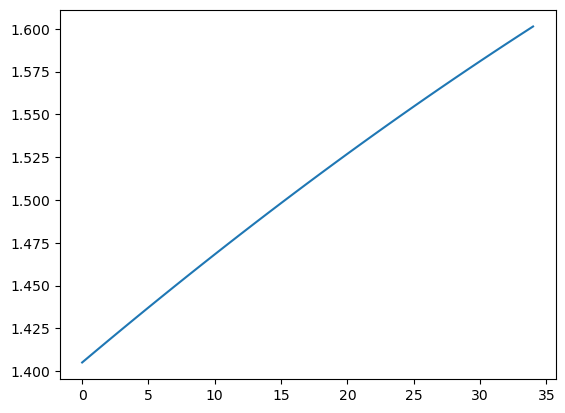

In [27]:
for i in range(int((block_max)/28800)):
    if weights_dict[i] not in edge_weights:
        edge_weights.append(weights_dict[i])

# plot weights distribution
plt.plot(edge_weights)
plt.show()

In [28]:
blocks_per_day = 28800

# loop, null and duplication filter

null id = 709

In [29]:
concat_frames.head(5)

,block_number_dec,masked_from,masked_to,gas_dec,value_dec
0,516712,0,1,516712,0
1,516712,2,1,516712,0
2,516712,3,4,516712,500000000000000000
3,516712,5,6,516712,12417540000000000
4,516715,7,8,516715,0


In [30]:
concat_frames.drop(['gas_dec', 'value_dec'], inplace=True, axis=1)

In [31]:
# loop filters
refined_data_df = concat_frames[concat_frames['masked_from'] != concat_frames['masked_to']]

In [32]:
print(len(refined_data_df))

2868064


In [33]:
del concat_frames

In [34]:
# sort block number
refined_data_df.sort_values('block_number_dec', inplace=True, ascending=True)

In [35]:
refined_data_df.head(5)

,block_number_dec,masked_from,masked_to
0,1,55,6
6,1,55,393
5,1,55,21275
4,1,55,353
3,1,55,11321


In [36]:
#drop duplicates
start_time = time.time()
refined_data_df.drop_duplicates(subset=['masked_from', 'masked_to'], keep='last', inplace=True)
print(time.time() - start_time)

0.15140461921691895


In [32]:
print(len(refined_data_df))

250765193


In [28]:
#refined_data_df.drop(refined_data_df[refined_data_df['masked_from']==3002].index, inplace=True)
# too long

In [38]:
refined_data_df_remove_null_ = refined_data_df[refined_data_df['masked_from'] != 709]

In [39]:
refined_data_df_remove_null = refined_data_df_remove_null_[refined_data_df_remove_null_['masked_to'] != 709]

In [40]:
print(len(refined_data_df_remove_null))

317454


In [41]:
refined_data_df_remove_null.head(5)

,block_number_dec,masked_from,masked_to
6,1,55,393
5,1,55,21275
4,1,55,353
3,1,55,11321
2,1,55,392


# Weights mapping

In [42]:
# add weights to edges
refined_data_df_remove_null["age_weights"] = refined_data_df_remove_null.apply(lambda row: weights_dict[int(row['block_number_dec']/28800)], axis=1)

/tmp/ipykernel_14579/3546326969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refined_data_df_remove_null["age_weights"] = refined_data_df_remove_null.apply(lambda row: weights_dict[int(row['block_number_dec']/28800)], axis=1)


In [43]:
refined_data_df_remove_null.head(5)

,block_number_dec,masked_from,masked_to,age_weights
6,1,55,393,1.40506
5,1,55,21275,1.40506
4,1,55,353,1.40506
3,1,55,11321,1.40506
2,1,55,392,1.40506


In [44]:
graph_data_save_path = root_dir +"graph_initialized_data.csv"
refined_data_df_remove_null.to_csv(graph_data_save_path, index=False)

# personalized weights

In [45]:
# data processing df_data_remove_loop
# extract features
to_weights_df = refined_data_df_remove_null[['masked_to', 'age_weights']]

# group receiver
node_age_weights = to_weights_df.groupby('masked_to').sum()

# sum calculation
# sum of weights
s_weights = float(node_age_weights["age_weights"].sum())

# personalized dict
personalized_weights = {k: v/s_weights for k, v in node_age_weights["age_weights"].items()}

In [46]:
print(len(personalized_weights.keys()))

53187


In [47]:
persn_dict_save_path = root_dir + "personalized_vetor.pickle"
with open(persn_dict_save_path, 'wb') as handle:
    pickle.dump(personalized_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)